# <font color=00ADB5>Building a CNN to classify images about the Overbite's problem</font>

What is an Overbite?

An overbite is a type of malocclusion, biting in an incorrect position, that causes the appearance of the front teeth protruding outwards over the jaw. Sometimes people call an overbite ‘buck teeth’, though this is a non-medical term and may be considered insensitive. Overbite issues can affect both children and adults.

The goal is to classify intraoral photos into two classes, increased or reduced overbite, described in the image below

The 2 classes are:

0. Overbite Aumentato - Deep Bite
1. Overbite Diminuito - Open Bite

***

## Building CNN model

In [47]:
#funziona con Python 3.11.8

import numpy as np 
import matplotlib.pyplot as plt 
import os 
import math 
import shutil 
import keras
import visualkeras
import random
import glob
from keras.layers import Conv2D, MaxPool2D, AvgPool2D, Dropout, Flatten, Dense
from keras.models import Sequential
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping, ModelCheckpoint
#from keras.preprocessing.image import load_img, img_to_array
from keras.utils import load_img, img_to_array


In [48]:
#count number of images in the respective classes 
ROOT_DIR = "dataset_overbite"
number_of_images = {}

for dir in os.listdir(ROOT_DIR):
    number_of_images[dir] = len(os.listdir(os.path.join(ROOT_DIR, dir)))

number_of_images.items()

dict_items([('Overbite Aumentato', 8), ('Overbite Diminuito', 7)])

## We will split the data such that
* 70 % for Train Data
* 15 % for Validation Data
* 15 % for Test Data

In [49]:
def dataFolder(p, split):

    if not os.path.exists("./"+p):
        os.mkdir("./"+p)

        for dir in os.listdir(ROOT_DIR):
            os.makedirs("./"+p+"/"+dir)
            for img in np.random.choice(a=os.listdir(os.path.join(ROOT_DIR, dir)) ,
                                        size= (math.floor(split*number_of_images[dir])-2) ,
                                        replace=False ):
                O = os.path.join(ROOT_DIR,dir,img)
                D = os.path.join("./"+p,dir)
                shutil.copy(O,D)
                os.remove(O)
    else:
        print( p + " Folder exist")       

In [50]:
dataFolder("train",0.7)

train Folder exist


In [51]:
dataFolder("val", 0.15)

val Folder exist


In [52]:
dataFolder("test", 0.15)

test Folder exist


## Model Building

In [53]:
# CNN Model
model = Sequential()

model.add(Conv2D(filters=16, kernel_size=(3,3), activation= 'relu', input_shape=(224, 224, 3) ))

model.add(Conv2D(filters=36, kernel_size=(3,3), activation= 'relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=64, kernel_size=(3,3), activation= 'relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Conv2D(filters=128, kernel_size=(3,3), activation= 'relu' ))
model.add(MaxPool2D(pool_size=(2,2)))

model.add(Dropout(rate= 0.25))

model.add(Flatten())
model.add(Dense(units=64 , activation= 'relu' ))
model.add(Dropout(rate= 0.25))

model.add(Dense(units=1, activation= 'sigmoid'))

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 222, 222, 16)      448       
                                                                 
 conv2d_9 (Conv2D)           (None, 220, 220, 36)      5220      
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 110, 110, 36)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 108, 108, 64)      20800     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 54, 54, 64)       0         
 2D)                                                             
                                                                 
 conv2d_11 (Conv2D)          (None, 52, 52, 128)      

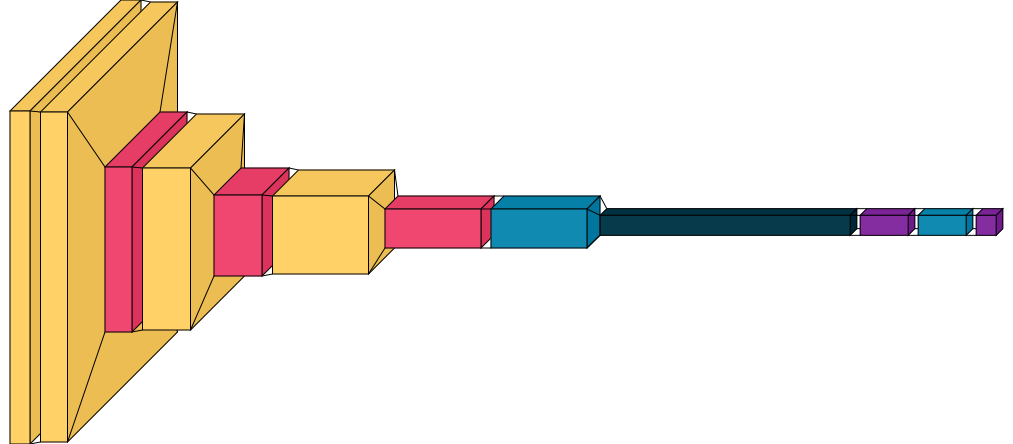

In [54]:

#visualkeras.layered_view(model=model, scale_xy=1.5,scale_z=1.0) 
visualkeras.layered_view(model=model, max_xy=550, max_z=250,scale_xy=1.5, scale_z=0.75)

In [55]:
optimizer = Adam(learning_rate=0.0001)
model.compile(loss= keras.losses.binary_crossentropy, 
              optimizer=optimizer,  
              metrics=['accuracy'])  
#optimizer = RMSprop(learning_rate=0.0001)
#model.compile(loss= keras.losses.binary_crossentropy,  
#              optimizer=optimizer, 
#              metrics=['accuracy'])  

## Preparing our data using Data Generator

In [56]:
def preprocessingImages1(path):
    
    image_data = ImageDataGenerator( zoom_range= 0.2, shear_range=0.2, rescale= 1./255, horizontal_flip= True) #Data Augumentation
    image = image_data.flow_from_directory(directory= path, target_size = (224,224), batch_size= 32, class_mode= 'binary')

    return image

In [57]:
train_data = preprocessingImages1(path="train")

Found 191 images belonging to 2 classes.


In [58]:
def preprocessingImages2(path):
    
    image_data = ImageDataGenerator(rescale= 1./255)
    image = image_data.flow_from_directory(directory= path, target_size = (224,224), batch_size= 32, class_mode= 'binary')

    return image

In [59]:
test_data= preprocessingImages2(path= "test")

Found 37 images belonging to 2 classes.


In [60]:
val_data= preprocessingImages2(path= "val")

Found 37 images belonging to 2 classes.


In [61]:
# Early Stopping and model check point

# early stopping
es = EarlyStopping(monitor="val_accuracy", min_delta= 0, patience=20, verbose=1, mode='auto')

# model check point
mc = ModelCheckpoint(monitor="val_accuracy", filepath="./bestmodel.h5", verbose=1, save_best_only=True, mode="auto") #importante inserire h5 come estensione

cd = [es,mc]

## Model Training

In [62]:
batch_size= 32
hs = model.fit(train_data,steps_per_epoch=train_data.samples // batch_size, epochs=100, verbose=1, validation_data=val_data, validation_steps=val_data.samples // batch_size, callbacks=cd)

Epoch 1/100
5/5 [==============================] - ETA: 0s - loss: 0.6988 - accuracy: 0.4843
Epoch 1: val_accuracy improved from -inf to 0.56250, saving model to .\bestmodel.h5
5/5 [==============================] - 22s 4s/step - loss: 0.6988 - accuracy: 0.4843 - val_loss: 0.6867 - val_accuracy: 0.5625
Epoch 2/100
5/5 [==============================] - ETA: 0s - loss: 0.7027 - accuracy: 0.5723
Epoch 2: val_accuracy did not improve from 0.56250
5/5 [==============================] - 16s 3s/step - loss: 0.7027 - accuracy: 0.5723 - val_loss: 0.7017 - val_accuracy: 0.5312
Epoch 3/100
5/5 [==============================] - ETA: 0s - loss: 0.6986 - accuracy: 0.5597
Epoch 3: val_accuracy did not improve from 0.56250
5/5 [==============================] - 15s 3s/step - loss: 0.6986 - accuracy: 0.5597 - val_loss: 0.6868 - val_accuracy: 0.5312
Epoch 4/100
5/5 [==============================] - ETA: 0s - loss: 0.6875 - accuracy: 0.5250
Epoch 4: val_accuracy did not improve from 0.56250
5/5 [=====

In [63]:
# Model Graphical Interpretation

h = hs.history
h.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

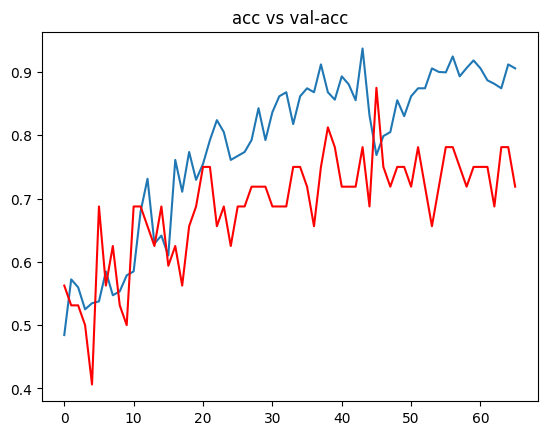

In [64]:
plt.plot(h['accuracy'])
plt.plot(h['val_accuracy'], c= "red")

plt.title("acc vs val-acc")
plt.show()

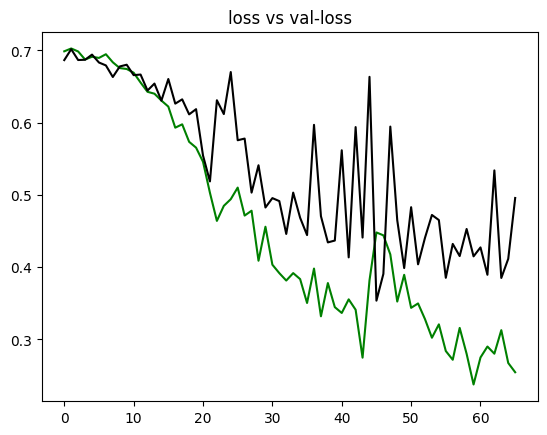

In [65]:
plt.plot(h['loss'], c= "green")
plt.plot(h['val_loss'], c= "black")

plt.title("loss vs val-loss")
plt.show()

In [66]:
from keras.models import load_model

model = load_model("bestmodel.h5")

## Model Accuracy

In [67]:
training_accuracy= model.evaluate(train_data)[1]
test_accuracy = model.evaluate(test_data)[1]
validation_accuracy= model.evaluate(val_data)[1]

print(f"Training accuracy of our model is: {training_accuracy * 100} %")
print(f"Testing accuracy of our model is: {test_accuracy * 100} %")
print(f"Validation accuracy of our model is: {validation_accuracy * 100} %")

2/2 [==============================] - 3s 346ms/step - loss: 0.4189 - accuracy: 0.8378
Training accuracy of our model is: 82.72251486778259 %
Testing accuracy of our model is: 78.37837934494019 %
Validation accuracy of our model is: 83.7837815284729 %


img: dataset_overbite\Overbite Diminuito\DSC_0021.JPG


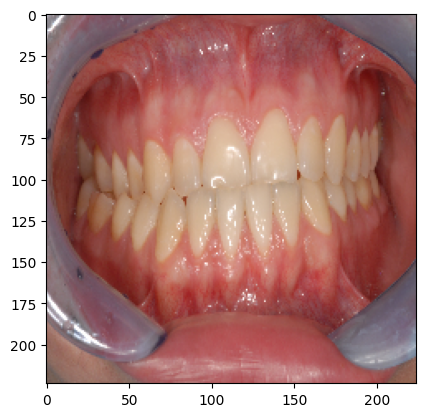

1/1 [==============================] - 0s 36ms/step
0.7562077
The image is classified as: Open Bite (Overbite Diminuito)


In [69]:
pred_paths = glob.glob("dataset_overbite\*\*.JPG")
path = random.choice(pred_paths)
print("img: " + path)

img = load_img(path,target_size=(224,224))
input_arr = img_to_array(img)/255

plt.imshow(input_arr)
plt.show()

input_arr.shape
input_arr = np.expand_dims(input_arr,axis=0)

pred = model.predict(input_arr)[0][0]
print(pred)
pred = pred < 0.5

if (pred==0):
    print("The image is classified as: Open Bite (Overbite Diminuito)")
else: 
    print("The image is classified as: Deep Bite (Overbite Aumentato)")